# Module 4 - Exploring Video Generation with **Amazon Nova Reel**

---

In this notebook, we'll explore the capabilities of Amazon Nova Reel, a powerful video generation model.

---

### Introduction

In this notebook, you'll explore Amazon Nova Reel, a cutting-edge video generation model that creates high-quality, studio-grade videos from text or a combination of text and images. Nova Reel enables text-to-video and image-and-text to video generation, producing up to two-minute videos in smooth 6-second segments at 1280x720 resolution and 24 FPS. Whether you're creating product showcases, dynamic marketing content, or storytelling animations, Nova Reel empowers businesses to generate compelling, visually rich video content with minimal effort—unlocking faster creative cycles and more personalized customer engagement.

Following the use case for Octank Dog Food for Nova Canvas (in the previous notebook lab), we'll create short video ads for a dog food company using two main features:

1. **Text-to-Video**: Generate a 6-second video from a text prompt.
2. **Image-to-Video**: Generate a 6-second video using both text and an input image.

### Prerequisites

**If you are running AWS-facilitated event**, all other pre-requisites are satisfied and you can go to the next section.

**If you are running this notebook as a self-paced lab**, then please make sure that:

1. Your AWS execution role has the necessary permissions to write and read from the dedicated S3 location.
2. The following minimum permissions are configured:
   - `bedrock:InvokeModel`
   - `s3:PutObject`
   - `s3:GetObject`
3. For better tracking of video generation jobs, we recommend adding these permissions:
   - `bedrock:GetAsyncInvoke`
   - `bedrock:ListAsyncInvokes`

**Note:** Ensure that these permissions are properly scoped to the specific S3 buckets and prefixes you intend to use for security best practices.

## 1. Setup

### 1.1 Import Libraries and Init Clients

First, let's import the required libraries and set up our Bedrock client

In [1]:
import os
import time
import boto3
import json
import base64
from botocore.exceptions import ClientError

account_id = boto3.client('sts').get_caller_identity().get('Account')

bedrock_runtime = boto3.client('bedrock-runtime')
s3_bucket = f"video-bucket-{account_id}"
local_output_folder = "output"

### 1.2 Create an S3 Bucket for Storing Results of Video Generation

In [2]:
# Create S3 bucket if s3_bucket doesn't exist
def create_bucket_if_not_exists(bucket_name, region="us-east-1"):
    """
    Create an S3 bucket if it doesn't exist.
    
    :param bucket_name: Name of the bucket
    :param region: Region to create the bucket in, e.g., 'us-east-1'
    :return: True if bucket was created or already exists, False on error
    """
    s3_client = boto3.client('s3', region_name=region)

    try:
        s3_client.head_bucket(Bucket=bucket_name)
        print(f"Bucket '{bucket_name}' already exists.")
        return True
    except ClientError as e:
        error_code = e.response['Error']['Code']
        if error_code == '404':
            try:
                if region == "us-east-1":
                    s3_client.create_bucket(Bucket=bucket_name)
                else:
                    location = {'LocationConstraint': region}
                    s3_client.create_bucket(Bucket=bucket_name,
                                            CreateBucketConfiguration=location)
                print(f"Bucket '{bucket_name}' created successfully.")
                return True
            except ClientError as e:
                print(f"Couldn't create bucket '{bucket_name}'. Error: {e}")
                return False
        else:
            print(f"Error checking bucket '{bucket_name}'. Error: {e}")
            return False
        
create_bucket_if_not_exists(s3_bucket)

Bucket 'video-bucket-446365592107' created successfully.


True

## 2. Use Case Implementation: Text to Video

#### Scenario

Octank, a premium dog food company, is launching a new line of gourmet dog food. The marketing team wants to create engaging short video ads to showcase their product's quality and appeal. They decide to leverage Amazon Nova Reel's text-to-video generation capabilities to create a captivating 6-second video clip that highlights their product.

#### What are the key parameters?

1. **text**: This is the prompt that describes the video you want to generate. It should be detailed and descriptive to guide the model in creating the desired output.

2. **durationSeconds**: This parameter sets the length of the generated video. Currently, Nova Reel supports 6-second videos.

3. **fps**: Frames per second of the output video. The current supported value is 24 fps.

4. **dimension**: This defines the resolution of the output video. The current supported dimension is 1280x720 pixels.

5. **seed**: An optional parameter that initializes the generation process. Using the same seed with identical parameters will produce the same video, allowing for reproducibility.

Let's generate our first video using these parameters:


In [3]:
prompt = """
Close-up shot of a shiny stainless steel bowl filled with gourmet dog food on a clean kitchen tile floor. Soft natural light from a nearby window highlights text textures. Slow camera zoom in, gradually revealing more detail of the appetizing meal. 4k resolution, cinematic quality.
"""

seed_num = 0

In [4]:
def generate_video_from_text(prompt, s3_output_path):
    model_input = {
        "taskType": "TEXT_VIDEO",
        "textToVideoParams": {
            "text": prompt
            },
        "videoGenerationConfig": {
            "durationSeconds": 6, 
            "fps": 24,
            "dimension": "1280x720",
            "seed": seed_num #random.randint(0, 2147483646),
        },
    }
    response = bedrock_runtime.start_async_invoke(
        modelId="amazon.nova-reel-v1:0",
        modelInput=model_input,
        outputDataConfig={"s3OutputDataConfig": {"s3Uri": f"s3://{s3_output_path}"}},
    )

    return response['invocationArn']


invocation_arn = generate_video_from_text(prompt, s3_bucket)
print(f"Video generation job started. Invocation ARN: {invocation_arn}")

Video generation job started. Invocation ARN: arn:aws:bedrock:us-east-1:446365592107:async-invoke/7apo43z2rwi2


### 2.1 Checking Job Progress

To check the progress of our video generation jobs

In [5]:
print("Waiting for video generation job to complete: ", end='')

while True:
    response = bedrock_runtime.get_async_invoke(invocationArn=invocation_arn)
    if response["status"].upper() == "COMPLETED":
        print(" done.")
        break
    print('█', end='', flush=True)
    time.sleep(5)

print("Job completed successfully with invocation ARN:", invocation_arn)

Waiting for video generation job to complete: ██████████████████████████████████████ done.
Job completed successfully with invocation ARN: arn:aws:bedrock:us-east-1:446365592107:async-invoke/7apo43z2rwi2


<div class="alert alert-block alert-info">
<b>Note:</b> On average, it takes about 3-4 mins to generate the video.
</div>


### 2.2 Download the Generated Video

Once the job is **completed**, we can download the generated video to local


In [15]:
def download_video_for_invocation_arn(invocation_arn, bucket_name, destination_folder):
    """
    This function downloads the video file for the given invocation ARN.
    """
    invocation_id = invocation_arn.split("/")[-1]

    # Create the local file path
    file_name = f"{invocation_id}.mp4"

    local_file_path = os.path.join(destination_folder, file_name)

    # Ensure the output folder exists
    os.makedirs(destination_folder, exist_ok=True)

    # Create an S3 client
    s3 = boto3.client("s3")

    # List objects in the specified folder
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=invocation_id)

    # Find the first MP4 file and download it.
    for obj in response.get("Contents", []):
        object_key = obj["Key"]
        if object_key.endswith(".mp4"):
            print(f"""Downloading "{object_key}"...""")
            s3.download_file(bucket_name, object_key, local_file_path)
            print(f"Downloaded to {local_file_path}")
            return local_file_path

    # If we reach this point, no MP4 file was found.
    print(f"Problem: No MP4 file was found in S3 at {bucket_name}/{invocation_id}")

    return local_file_path
    
video_path = download_video_for_invocation_arn(invocation_arn, s3_bucket, local_output_folder)

Downloaded to output/1680gdpmc6bk.mp4


In [16]:
# Preiview generated video
from IPython.display import Video

Video(video_path, width=900)

## 3. Use Case Implementation: Image to Video

#### Scenario

Now that Octank has a finalized design for their dog food package, they want to create a video that showcases the product from different angles. They decide to use Nova Reel's image-to-video feature to generate a 6-second video of the product rotating clockwise on a kitchen countertop

#### What are the key parameters?
- **text**: This is the prompt that describes the desired video animation.
- **image**: The base64-encoded image that serves as the reference for the video.
- **durationSeconds**: The length of the generated video (6 seconds).
- **fps**: Frames per second of the output video (24 fps).
- **dimension**: The resolution of the output video (1280x720 pixels).
- **seed**: An optional parameter for reproducibility.

Let's generate our video using these parameters:


In [8]:
# Define function to convert image to base64 object
def image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [9]:
# Customized parameters
image_path = "images/video_input.png"
base64_image = image_to_base64(image_path)

prompt = "Camera slowly rotates in clockwise direction around the dog food package on a kitchen countertop"

seed_num = 0  # Change this for different results

image_format = image_path.split(".")[-1]
if image_format not in ["png", "jpeg"]:
    assert print("Only .png or .jpeg supported")

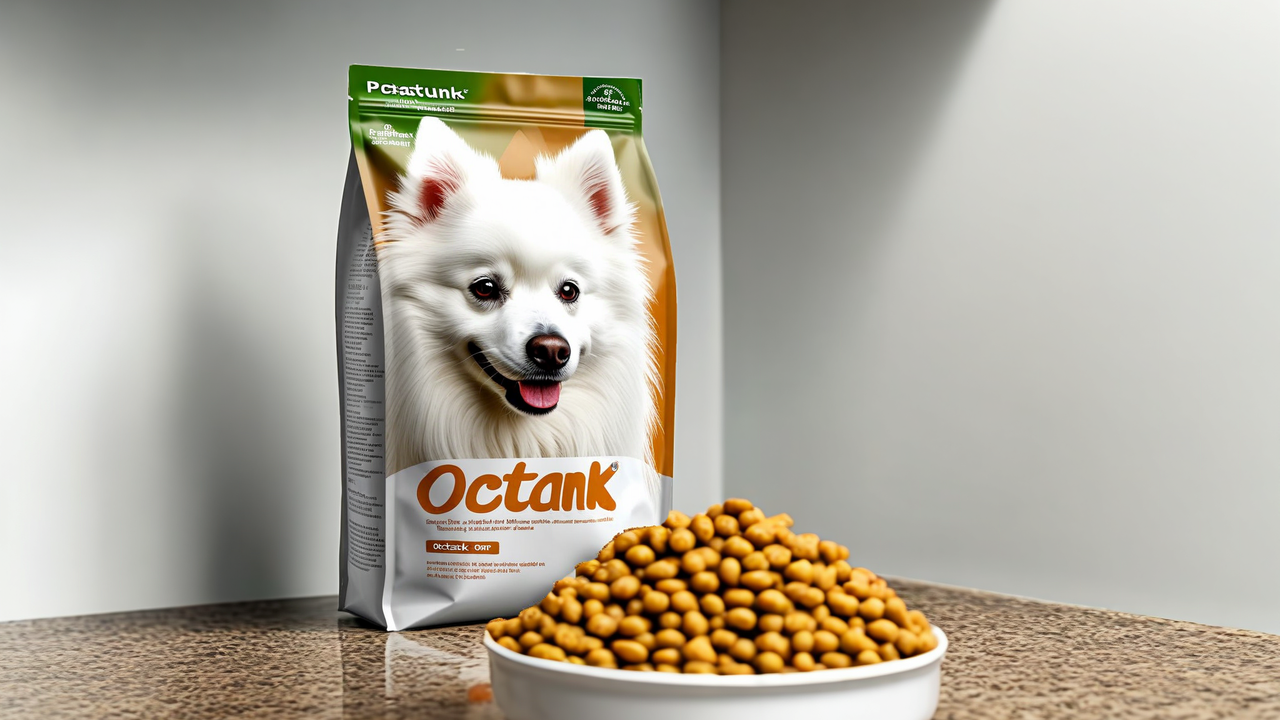

In [10]:
# Preview image to generate video from
from IPython.display import Image

Image(image_path)

In [11]:
def generate_video_from_image(prompt, base64_image, s3_output_path, image_format):
    model_input = {
        "taskType": "TEXT_VIDEO",
        "textToVideoParams": {
            "text": prompt,
            "images": [
                {
                    "format": image_format,  # May be "png" or "jpeg"
                    "source": {
                        "bytes": base64_image
                    }
                }
            ]
        },
        "videoGenerationConfig": {
            "durationSeconds": 6, 
            "fps": 24,
            "dimension": "1280x720",
            "seed": seed_num
        },
    }
    response = bedrock_runtime.start_async_invoke(
        modelId="amazon.nova-reel-v1:0",
        modelInput=model_input,
        outputDataConfig={"s3OutputDataConfig": {"s3Uri": f"s3://{s3_output_path}"}},
    )

    return response['invocationArn']

invocation_arn = generate_video_from_image(prompt, base64_image, s3_bucket, image_format)
print(f"Video generation job started. Invocation ARN: {invocation_arn}")

Video generation job started. Invocation ARN: arn:aws:bedrock:us-east-1:446365592107:async-invoke/1680gdpmc6bk


### 3.1 Check status and download the generated video

In [12]:
print("Waiting for video generation job to complete: ", end='')

while True:
    response = bedrock_runtime.get_async_invoke(invocationArn=invocation_arn)
    if response["status"].upper() == "COMPLETED":
        print(" done.")
        break
    print('█', end='', flush=True)
    time.sleep(5)

print("Job completed successfully with invocation ARN:", invocation_arn)

Waiting for video generation job to complete: ███████████████████████████████████ done.
Job completed successfully with invocation ARN: arn:aws:bedrock:us-east-1:446365592107:async-invoke/1680gdpmc6bk


<div class="alert alert-block alert-info">
<b>Note:</b> On average, it takes about 3-4 mins to generate the video.
</div>

### 3.2 Download the Generated Video

In [13]:
# Once the job is complete, download the video
video_path = video_path = download_video_for_invocation_arn(invocation_arn, s3_bucket, local_output_folder)

Downloaded to output/1680gdpmc6bk.mp4


In [14]:
# Preiview generated video
from IPython.display import Video

Video(video_path, width=900)

## 4. Conclusion and Next Steps

In this notebook, we've demonstrated how to use Amazon Nova Reel to generate short video ads for a dog food company. We explored both text-to-video and image-to-video generation capabilities, providing a powerful tool for creating engaging visual content.

### Next Steps

Please return to the workshop instructions page and proceed to your next workshop module, if needed.